## import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras.models import Model
from keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Prepare paths of input images and target segmentation masks for train and test set

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5
IMG_CHANNELS = 3

IMG_PATH = '/kaggle/input/oil-spill/oil-spill/train/images'
LABELS_PATH = '/kaggle/input/oil-spill/oil-spill/train/labels'

IMG_PATH_TEST = '/kaggle/input/oil-spill/oil-spill/test/images'
LABELS_PATH_TEST = '/kaggle/input/oil-spill/oil-spill/test/labels'

In [3]:
# Get a list of all image filenames in the directory
IMG_IDS = sorted(os.listdir(IMG_PATH))
LABELS_IDS = sorted(os.listdir(LABELS_PATH))

IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))

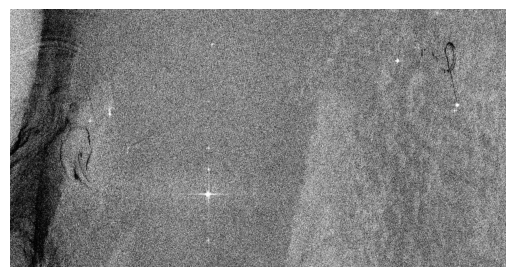

Randomly selected image: img_0006.jpg


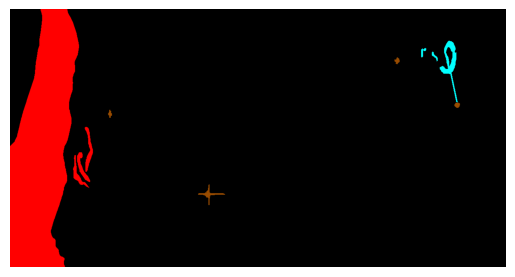

Randomly selected mask: img_0006.png


In [4]:
# Choose a random image and mask filename from the list
random_image_name = IMG_IDS[5]
random_mask_name = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

In [5]:
COLOR_MAP = [
    [0, 0, 0], 
    [0, 255, 255], 
    [255, 0, 0], 
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [6]:
train_images = []
train_masks = []

test_images = []
test_masks = []

## train set

In [7]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [00:50<00:00, 19.83it/s]


In [8]:
train_masks.shape

(1002, 256, 256, 1)

In [9]:
unique_values = np.unique(train_masks)
print("Unique values in train_masks:", unique_values)

Unique values in train_masks: [0 1 2 3 4]


## Plotting the train images 

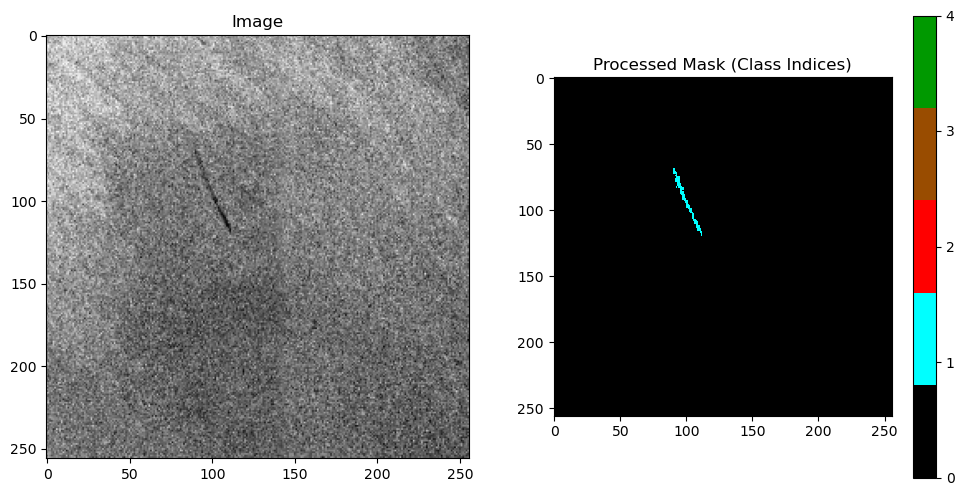

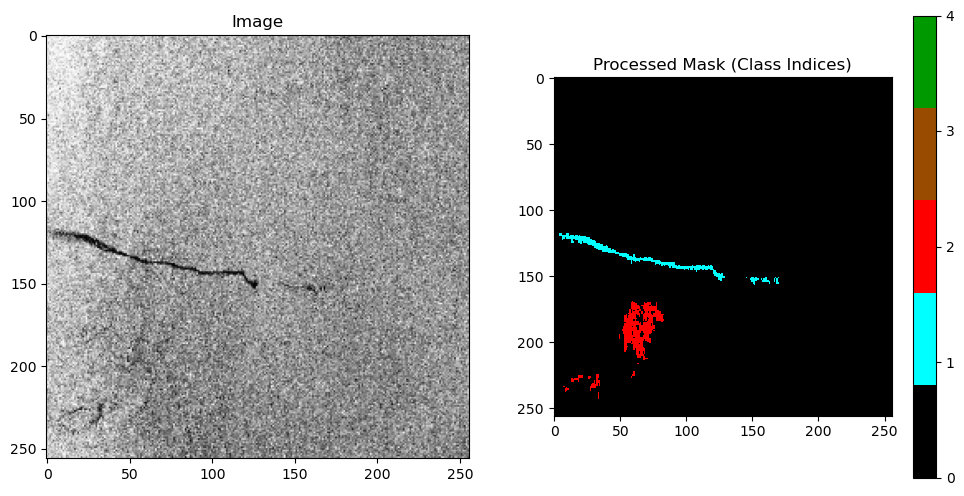

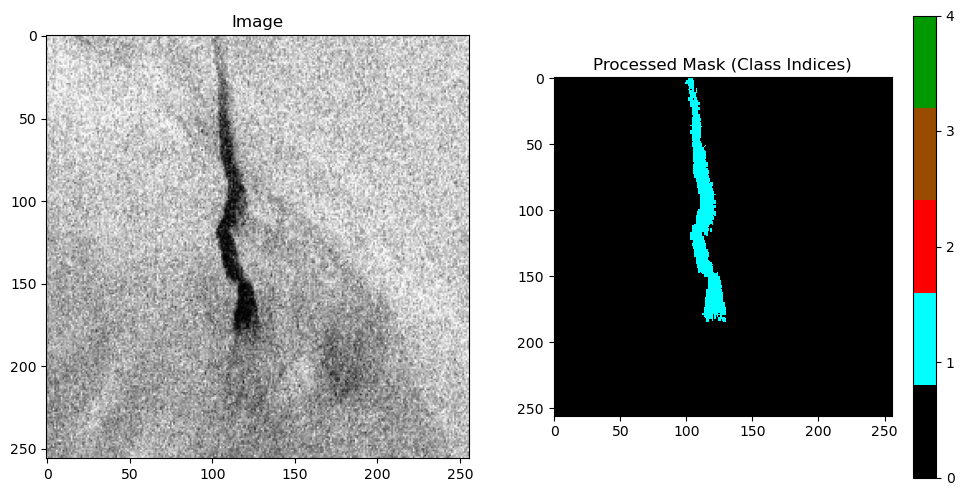

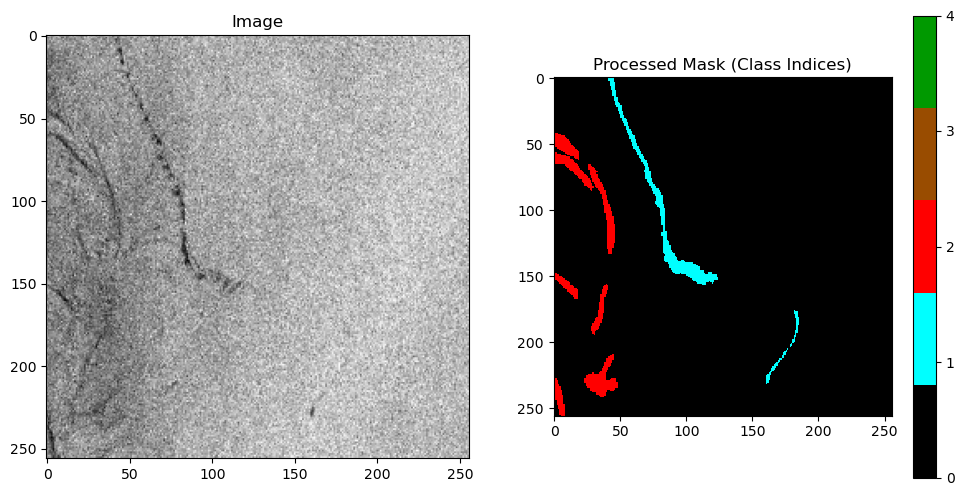

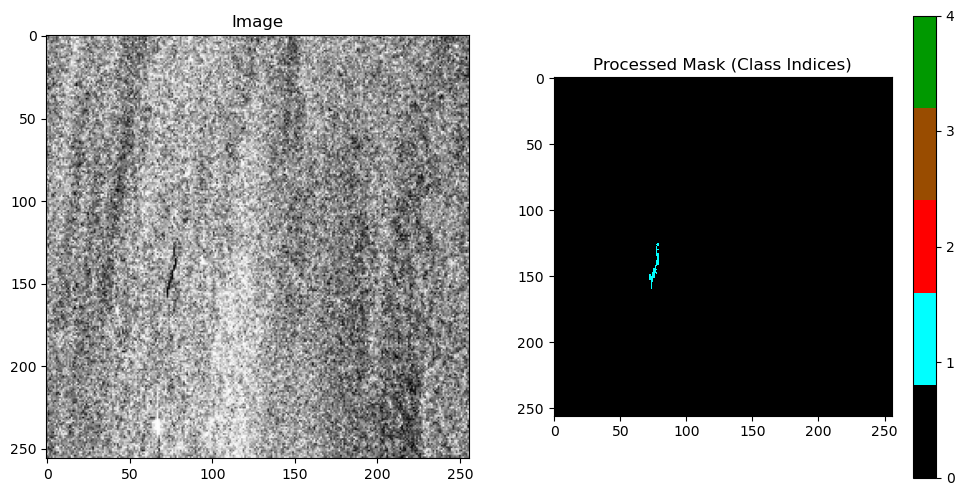

In [10]:
import matplotlib.colors as mcolors

# Scale the color values in COLOR_MAP to the range [0, 1]
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]

# Define a consistent color map based on the scaled COLOR_MAP
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(train_images[i])  # Display the image
    plt.title("Image")

    plt.subplot(1, 2, 2)  # Subplot for the processed mask
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

## test set

In [11]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

100%|██████████| 110/110 [00:05<00:00, 19.98it/s]


In [12]:
test_masks.shape

(110, 256, 256, 1)

In [13]:
unique_values = np.unique(test_masks)
print("Unique values in test_masks:", unique_values)

Unique values in test_masks: [0 1 2 3 4]


## Using to_categorical for the masks

In [14]:
from keras.utils import to_categorical

train_masks = to_categorical(train_masks, num_classes = 5)

In [15]:
print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [16]:
print(test_images.shape)
print(test_masks.shape)

(110, 256, 256, 3)
(110, 256, 256, 1)


In [17]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0 1 2 3 4]


## train masks pixel count

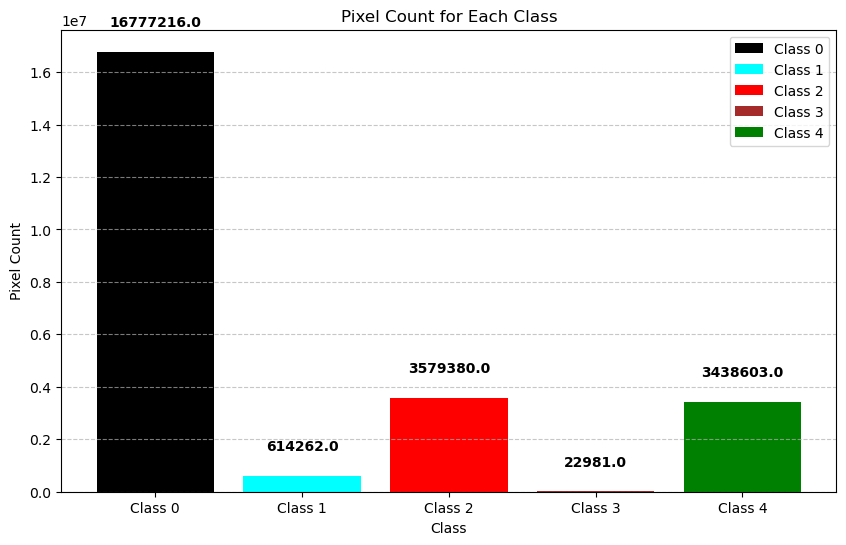

In [18]:
num_classes = 5

# Calculate pixel counts for each class
class_pixel_counts = np.sum(train_masks, axis=(0, 1, 2))

# Class labels
class_labels = [f'Class {i}' for i in range(num_classes)]

# Define different colors for each class
colors = ['black', 'cyan', 'red', 'brown', 'green']

# Plotting the bar graph with different colors and added styling
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_pixel_counts, color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class')

# Adding legend
plt.legend(bars, class_labels)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value annotations on top of each bar
for bar, count in zip(bars, class_pixel_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05 * max(class_pixel_counts),
             f'{count}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [19]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# UNet Model

In [20]:
def UNet(input_shape, IMG_CLASSES):

    inputs = Input(input_shape)

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(IMG_CLASSES, (1,1), activation="softmax")(c9)

    model = Model(inputs, outputs)
    return model

In [21]:
unet_model = UNet(input_shape, IMG_CLASSES)

unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [22]:
tf.keras.backend.clear_session()

unet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics='accuracy')

## Train the unet_model

In [23]:
unet_history = unet_model.fit(train_images, train_masks,
                    epochs=30,  # changed from 100 to 30
                    batch_size=16,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/30


2025-02-22 08:51:26.824151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


57/57 [==============================] - 29s 235ms/step - loss: 0.5995 - accuracy: 0.8621 - val_loss: 0.4584 - val_accuracy: 0.8967
Epoch 2/30
57/57 [==============================] - 10s 179ms/step - loss: 0.4740 - accuracy: 0.8821 - val_loss: 0.3924 - val_accuracy: 0.8973
Epoch 3/30
57/57 [==============================] - 10s 181ms/step - loss: 0.3997 - accuracy: 0.8871 - val_loss: 0.2938 - val_accuracy: 0.9148
Epoch 4/30
57/57 [==============================] - 10s 183ms/step - loss: 0.3663 - accuracy: 0.8857 - val_loss: 0.2869 - val_accuracy: 0.9126
Epoch 5/30
57/57 [==============================] - 11s 185ms/step - loss: 0.3487 - accuracy: 0.8880 - val_loss: 0.2539 - val_accuracy: 0.9111
Epoch 6/30
57/57 [==============================] - 11s 187ms/step - loss: 0.3134 - accuracy: 0.8916 - val_loss: 0.2445 - val_accuracy: 0.9122
Epoch 7/30
57/57 [==============================] - 11s 189ms/step - loss: 0.3009 - accuracy: 0.8974 - val_loss: 0.2274 - val_accuracy: 0.9239
Epoch 8/30

## model visualization

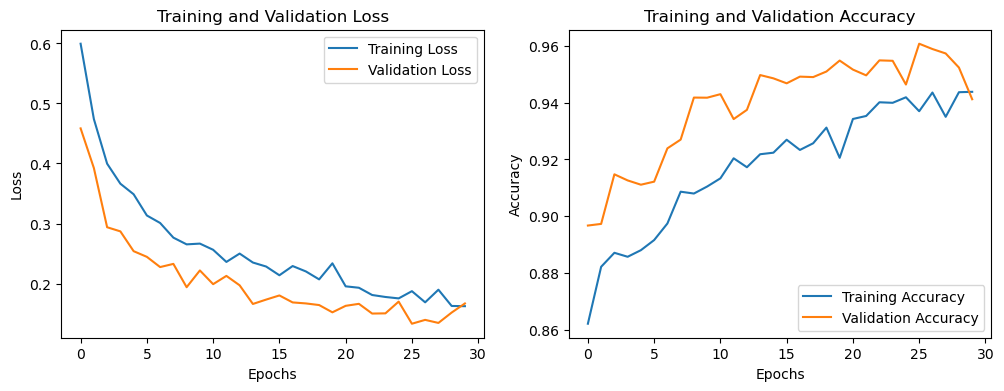

In [24]:
# Access the training history
unet_loss = unet_history.history['loss']
unet_val_loss = unet_history.history['val_loss']
unet_accuracy = unet_history.history['accuracy']
unet_val_accuracy = unet_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unet_loss, label='Training Loss')
plt.plot(unet_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(unet_accuracy, label='Training Accuracy')
plt.plot(unet_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## prediciton visualization

1/1 [==============================] - 1s 709ms/step


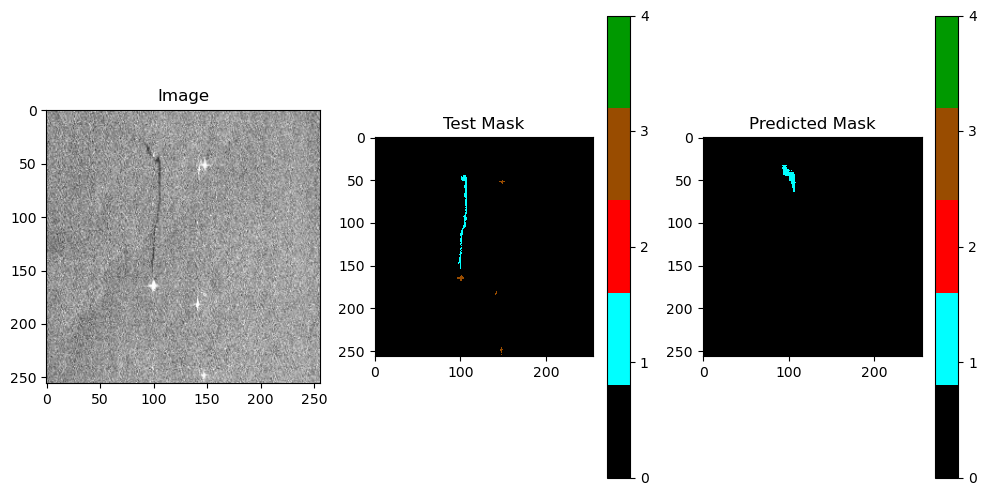

1/1 [==============================] - 0s 19ms/step


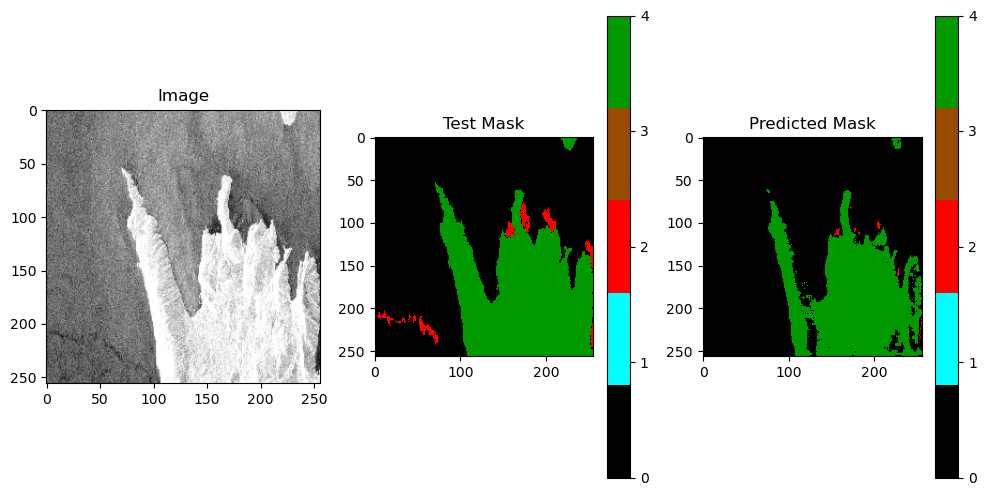

1/1 [==============================] - 0s 23ms/step


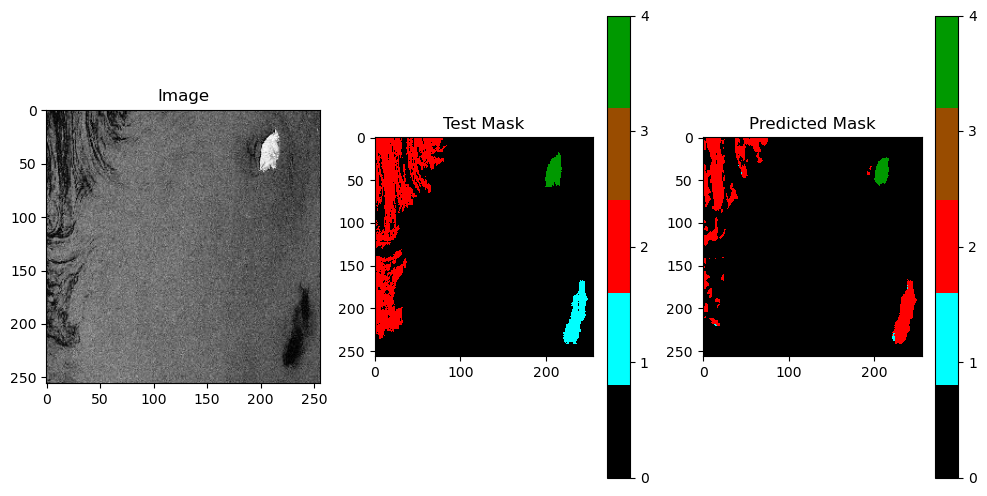

1/1 [==============================] - 0s 20ms/step


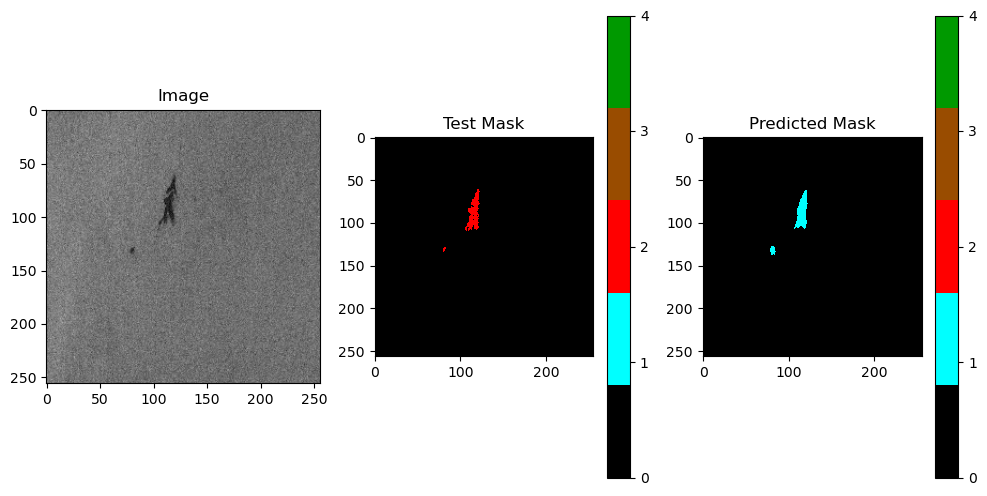

1/1 [==============================] - 0s 26ms/step


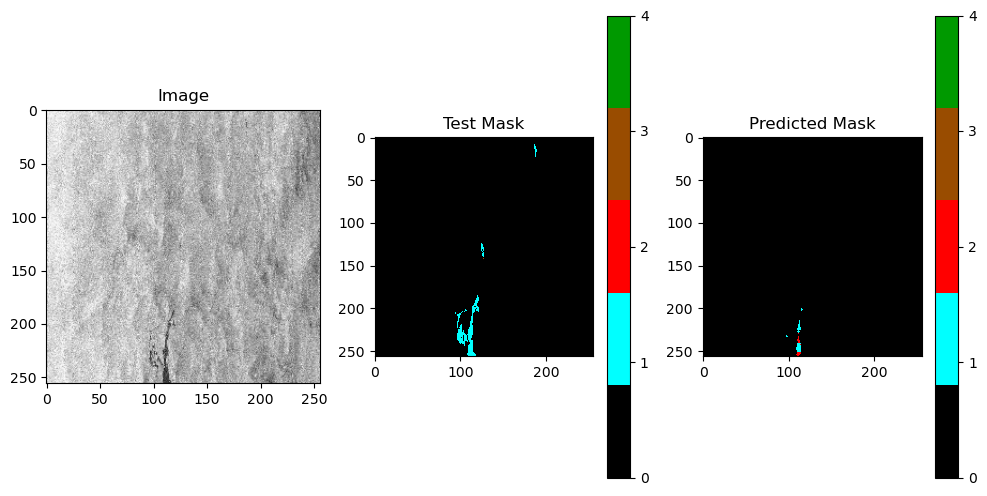

1/1 [==============================] - 0s 19ms/step


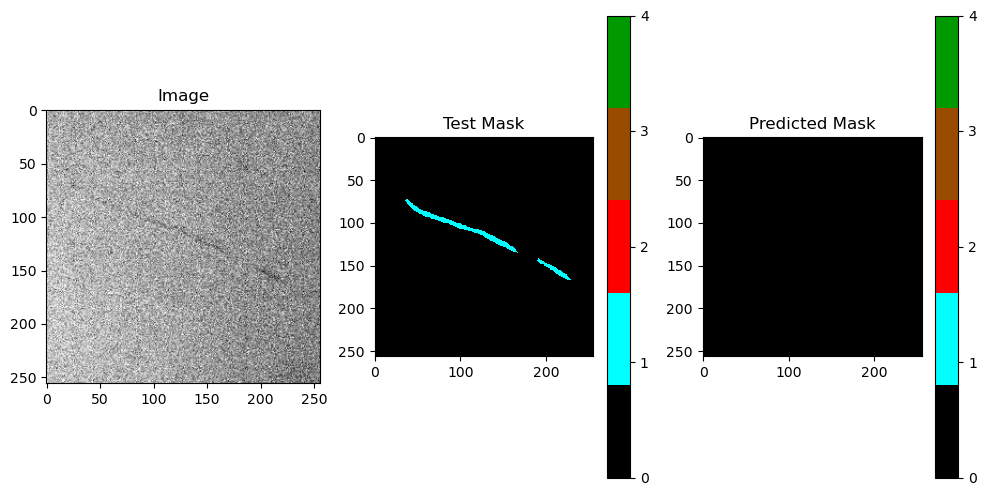

1/1 [==============================] - 0s 33ms/step


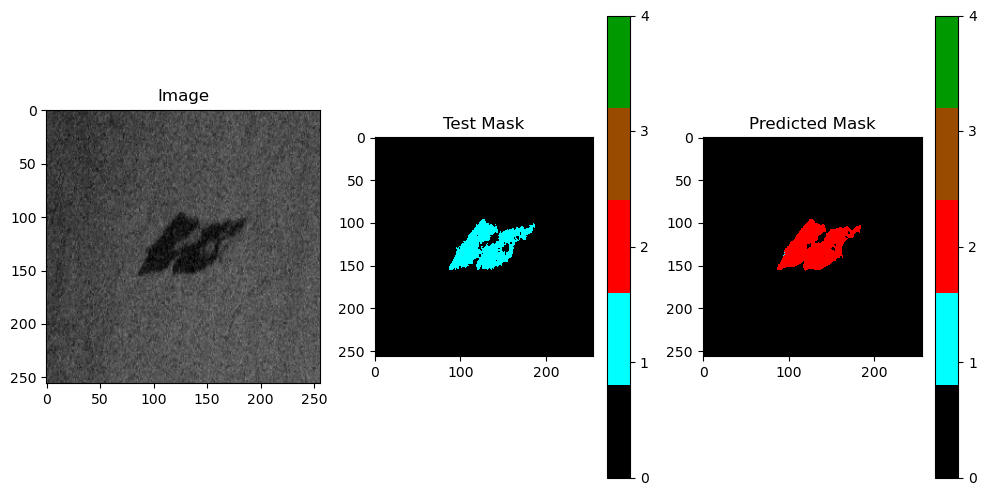

1/1 [==============================] - 0s 20ms/step


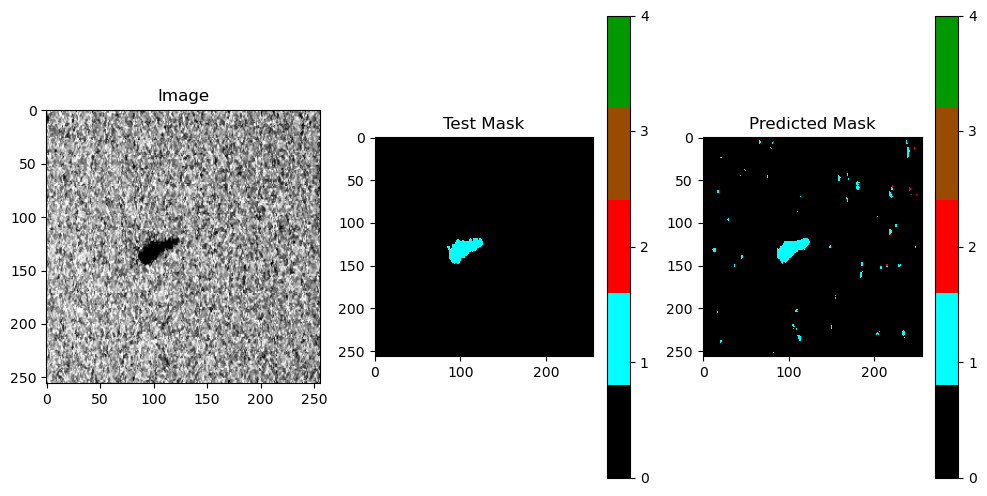

1/1 [==============================] - 0s 19ms/step


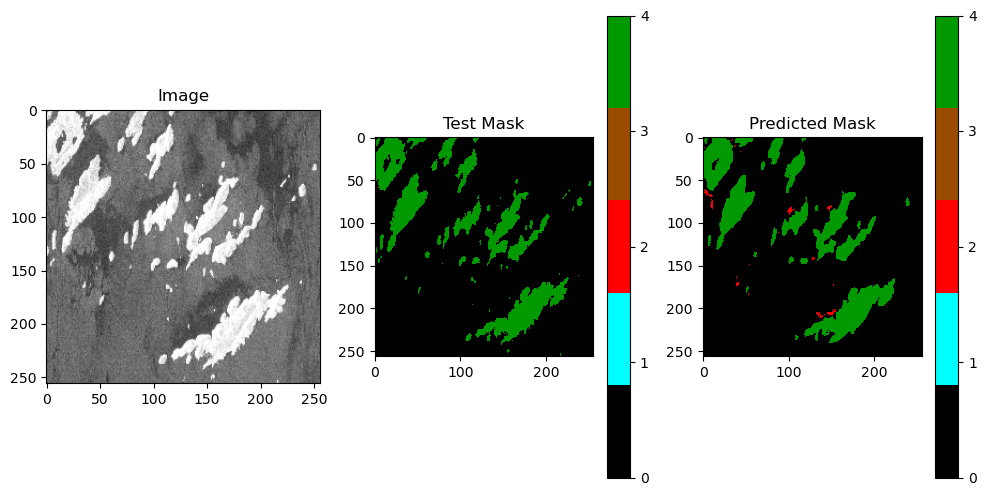

1/1 [==============================] - 0s 21ms/step


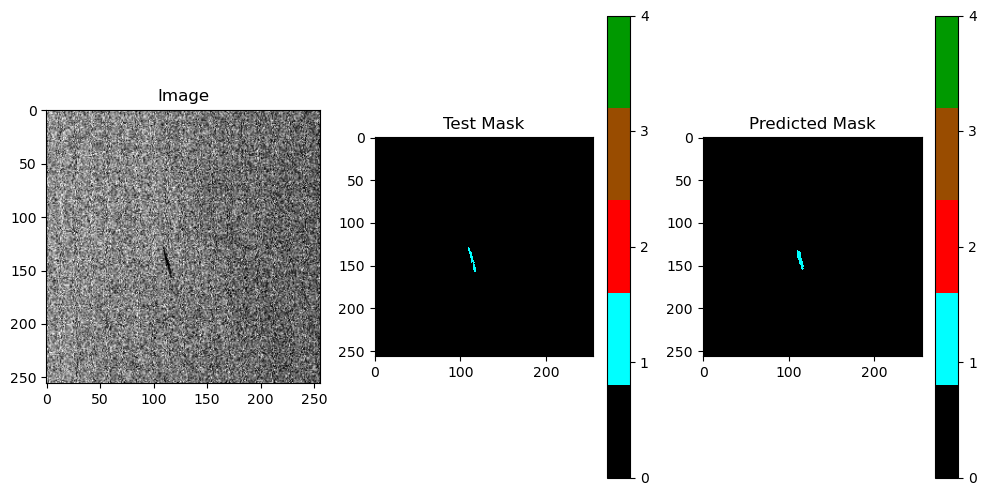

In [25]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    
    # Test Image 
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")
    
    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_unet = unet_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_unet = np.argmax(prediction_unet, axis=3)[0, :, :]
    plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")
    
    plt.show()


## Confusion matrix for Unet model

In [26]:
prediction_unet = unet_model.predict(test_images)

print(test_masks.shape)
print(prediction_unet.shape)

4/4 [==============================] - 4s 510ms/step
(110, 256, 256, 1)
(110, 256, 256, 5)


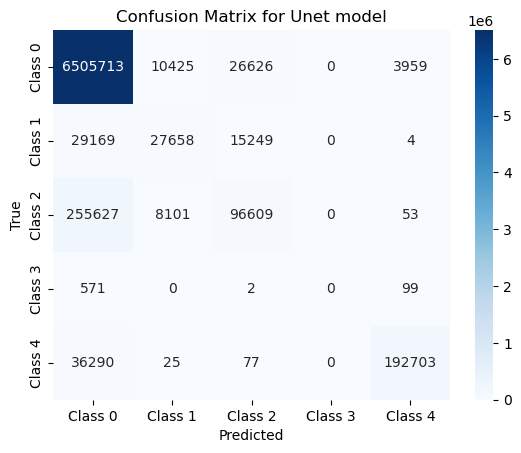

In [27]:
# Flatten the arrays to 1D
unet_true_labels = test_masks.flatten()
unet_predicted_labels = np.argmax(prediction_unet, axis=-1).flatten()

# Create the confusion matrix
cm = confusion_matrix(unet_true_labels, unet_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()

In [28]:
# Calculate precision, recall, and F1 score
precision = precision_score(unet_true_labels, unet_predicted_labels, average='weighted')
recall = recall_score(unet_true_labels, unet_predicted_labels, average='weighted')
f1 = f1_score(unet_true_labels, unet_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9373
Recall: 0.9464
F1 Score: 0.9363


# DeepLapV3 Model

In [29]:
# atrous_spatial_pyramid_pooling
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [30]:
def DeepLabV3Plus(input_shape, IMG_CLASSES):
    # Inputs
    inputs = layers.Input(input_shape)

    # Pre-trained ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Pre-trained ResNet50 Output
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    # Get low-level features
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    # Outputs
    x = Conv2D(IMG_CLASSES, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    # Model
    model = Model(inputs=inputs, outputs=x)
    return model

In [31]:
deeplab_model = DeepLabV3Plus(input_shape, IMG_CLASSES)
deeplab_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [32]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [33]:
# treating all classes equally in terms of their contribution to the loss.
class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [34]:
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss(class_weights = class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + focal_loss

Segmentation Models: using `tf.keras` framework.


In [35]:
tf.keras.backend.clear_session()

# # Define the learning rate
# learning_rate = 10e-5

# # Create an instance of the Adam optimizer with the specified learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

deeplab_model.compile(optimizer='adam', loss=total_loss, metrics = ["accuracy", jaccard_coef])

In [36]:
deeplab_history = deeplab_model.fit(train_images, train_masks,
                            epochs=20, # changed from 50 to 5
                            batch_size=16,
                            validation_split=0.1,
                            verbose=1)

Epoch 1/20
57/57 [==============================] - 90s 670ms/step - loss: 0.9472 - accuracy: 0.8813 - jaccard_coef: 0.7017 - val_loss: 1.7354 - val_accuracy: 0.0795 - val_jaccard_coef: 0.0393
Epoch 2/20
57/57 [==============================] - 28s 489ms/step - loss: 0.9234 - accuracy: 0.9270 - jaccard_coef: 0.8292 - val_loss: 1.0501 - val_accuracy: 0.8833 - val_jaccard_coef: 0.8053
Epoch 3/20
57/57 [==============================] - 28s 491ms/step - loss: 0.9149 - accuracy: 0.9304 - jaccard_coef: 0.8404 - val_loss: 1.4200 - val_accuracy: 0.4366 - val_jaccard_coef: 0.2806
Epoch 4/20
57/57 [==============================] - 28s 497ms/step - loss: 0.9111 - accuracy: 0.9244 - jaccard_coef: 0.8403 - val_loss: 0.9989 - val_accuracy: 0.8967 - val_jaccard_coef: 0.8136
Epoch 5/20
57/57 [==============================] - 28s 493ms/step - loss: 0.9018 - accuracy: 0.9384 - jaccard_coef: 0.8660 - val_loss: 0.9971 - val_accuracy: 0.6384 - val_jaccard_coef: 0.3736
Epoch 6/20
57/57 [=================

## model visualization

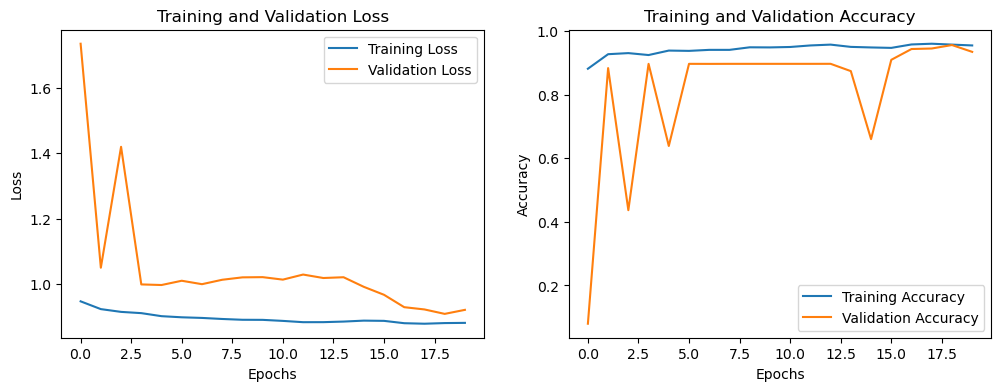

In [37]:
# Access the training history
deeplab_loss = deeplab_history.history['loss']
deeplab_val_loss = deeplab_history.history['val_loss']
deeplab_accuracy = deeplab_history.history['accuracy']
deeplab_val_accuracy = deeplab_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(deeplab_loss, label='Training Loss')
plt.plot(deeplab_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(deeplab_accuracy, label='Training Accuracy')
plt.plot(deeplab_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## prediciton visualization

1/1 [==============================] - 2s 2s/step


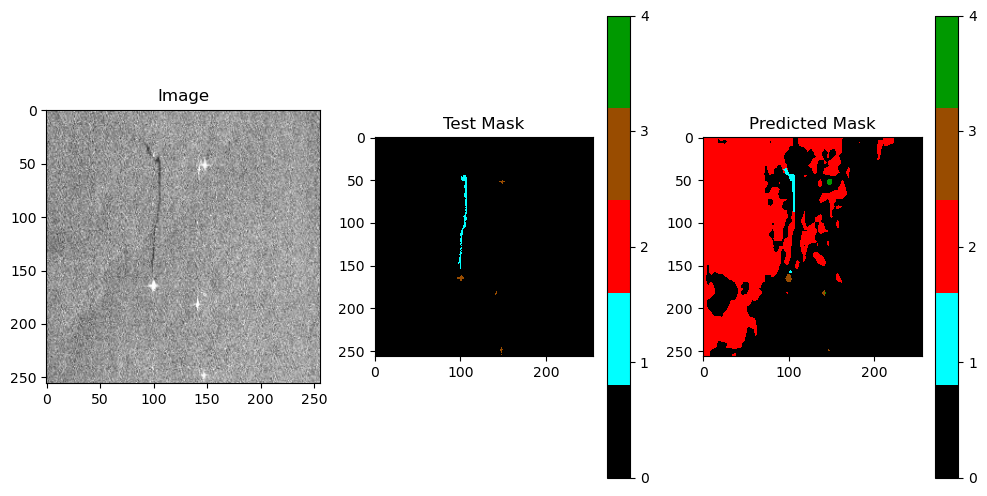

1/1 [==============================] - 0s 23ms/step


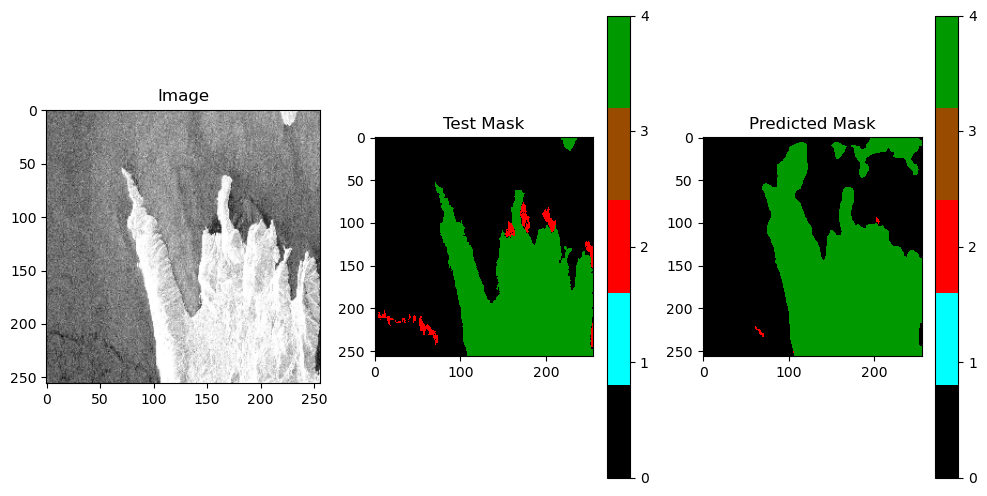

1/1 [==============================] - 0s 22ms/step


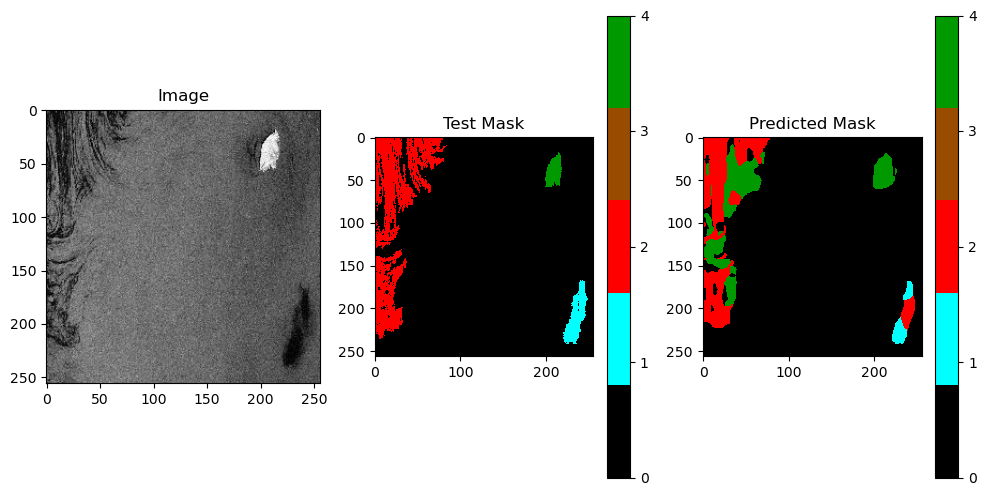

1/1 [==============================] - 0s 23ms/step


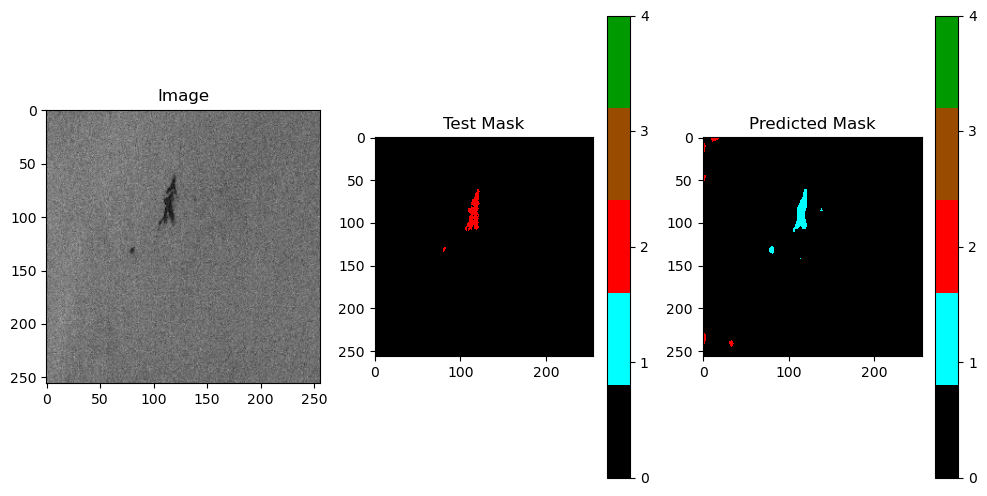

1/1 [==============================] - 0s 22ms/step


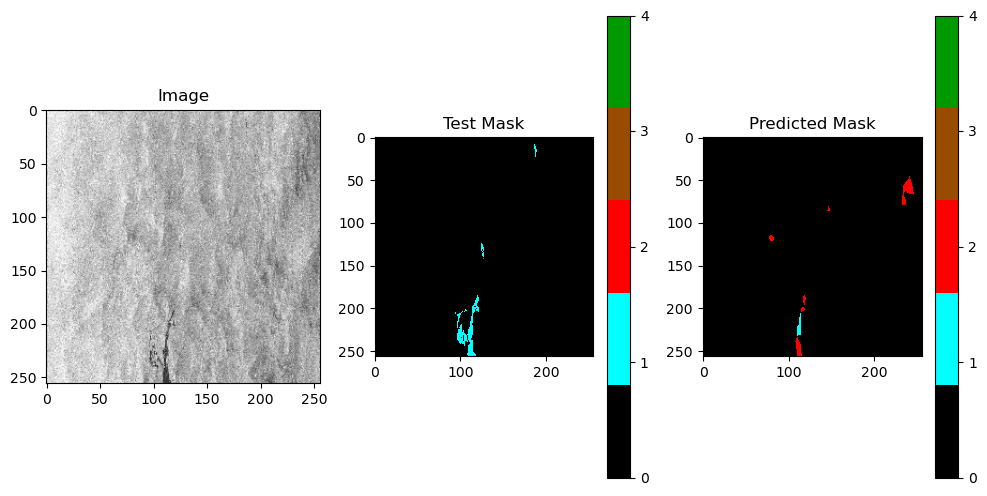

1/1 [==============================] - 0s 22ms/step


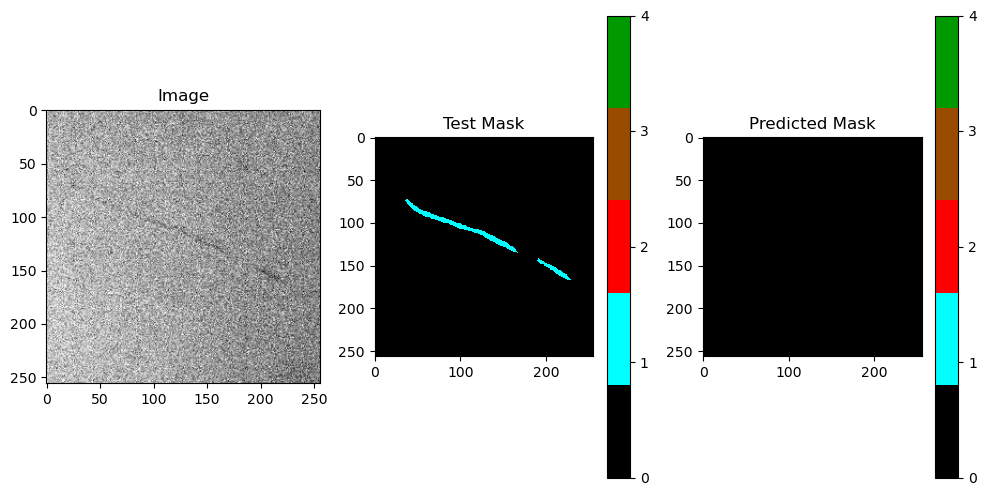

1/1 [==============================] - 0s 23ms/step


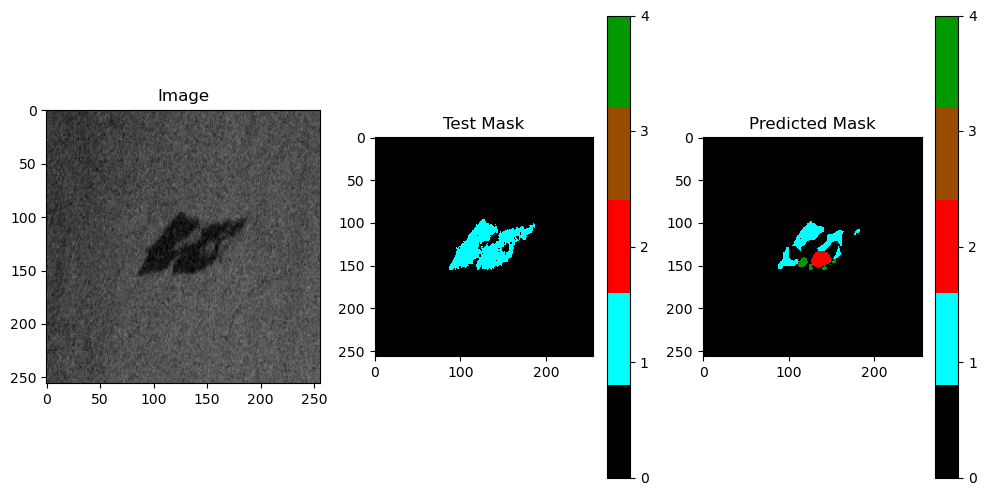

1/1 [==============================] - 0s 24ms/step


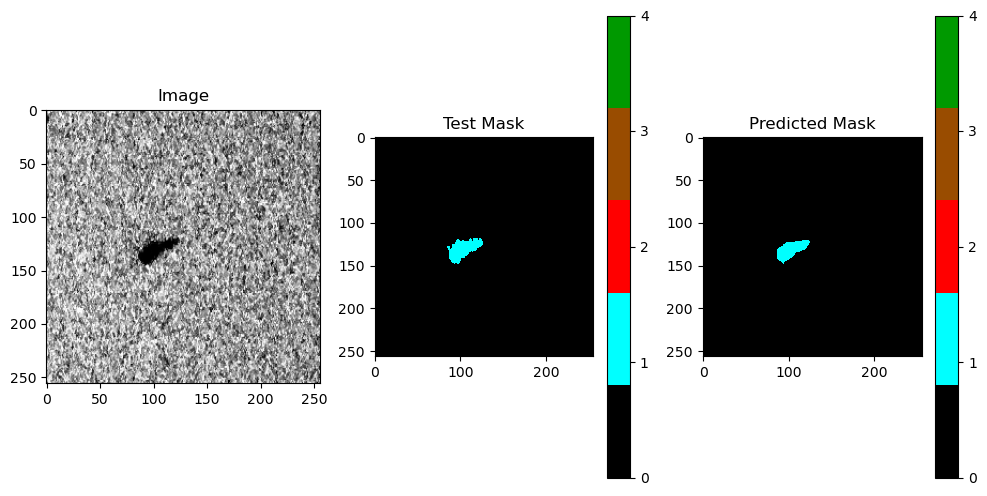

1/1 [==============================] - 0s 24ms/step


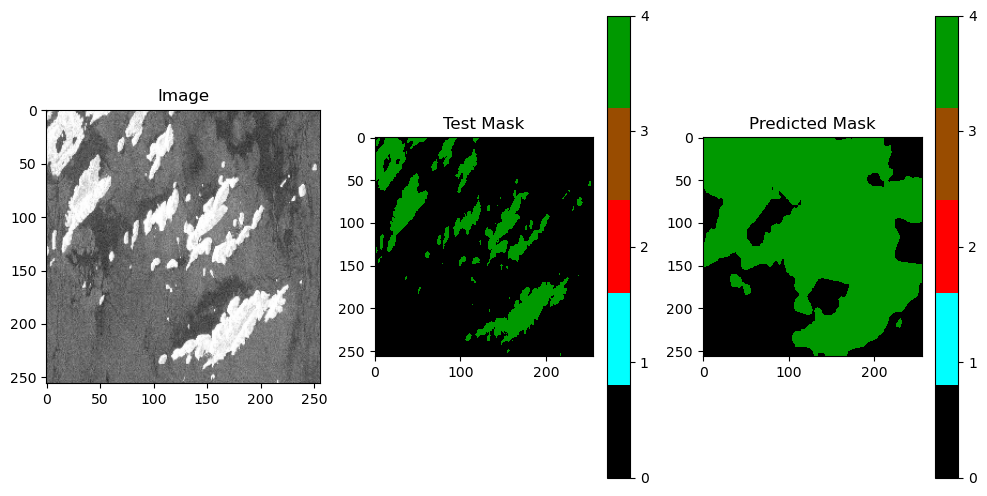

1/1 [==============================] - 0s 24ms/step


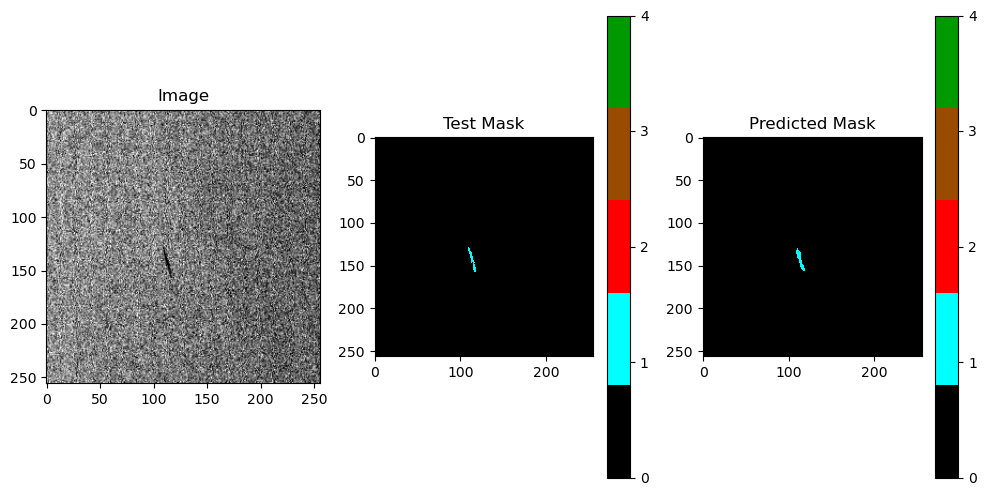

In [38]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    
    # Test Image 
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")
    
    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_deeplab = deeplab_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_deeplab = np.argmax(prediction_deeplab, axis=3)[0, :, :]
    plt.imshow(predicted_mask_deeplab.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")
    
    plt.show()


## Confusion matrix for deeplabV3 model

In [39]:
prediction_deeplab = deeplab_model.predict(test_images)

print(test_masks.shape)
print(prediction_deeplab.shape)

4/4 [==============================] - 10s 1s/step
(110, 256, 256, 1)
(110, 256, 256, 5)


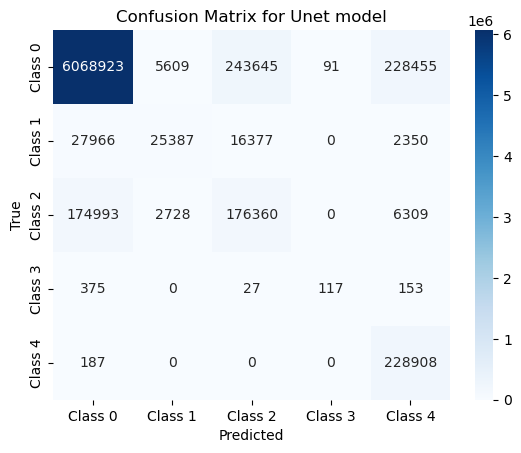

In [40]:
# Flatten the arrays to 1D
deeplab_true_labels = test_masks.flatten()
deeplab_predicted_labels = np.argmax(prediction_deeplab, axis=-1).flatten()

# Create the confusion matrix
cm = confusion_matrix(deeplab_true_labels, deeplab_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()


In [41]:
# Calculate precision, recall, and F1 score
precision = precision_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')
recall = recall_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')
f1 = f1_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9221
Recall: 0.9016
F1 Score: 0.9077


# PSPNet model

In [42]:
# from keras.layers import Lambda

# # PSPNet Architecture
# def PSPNet(input_shape, IMG_CLASSES):
#     inputs = Input(input_shape)

#     resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

#     pyramid_layers = []
    
#     for pool_size in [1, 2, 3, 6]:
#         pyramid = AveragePooling2D(pool_size=(pool_size, pool_size))(resnet.output)
#         pyramid = Conv2D(128, (1, 1), activation='relu')(pyramid)
#         pyramid = Lambda(lambda x: tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH), method='bilinear'))(pyramid)
#         pyramid_layers.append(pyramid)

#     merged = Concatenate(axis=-1)(pyramid_layers)
#     merged = BatchNormalization()(merged)

#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(merged)
#     x = Dropout(0.5)(x)
#     x = Conv2D(IMG_CLASSES, (1, 1), activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=x)
#     return model

In [43]:
# pspnet_model = PSPNet(input_shape, IMG_CLASSES)
# pspnet_model.summary()

In [44]:
# tf.keras.backend.clear_session()

# # # Define the learning rate
# # learning_rate = 10e-5

# # # Create an instance of the Adam optimizer with the specified learning rate
# # optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# pspnet_model.compile(optimizer='adam', loss=total_loss, metrics = ["accuracy", jaccard_coef])

In [45]:
# history = pspnet_model.fit(train_images, train_masks,
#                             epochs=50,
#                             batch_size=8,
#                             validation_split=0.1,
#                             verbose=1)

## model visualization

In [46]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)

# plt.plot(epochs, loss, 'r', label="Training Loss")
# plt.plot(epochs, val_loss, 'c', label="Validation Loss")
# plt.title("Training Vs Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [47]:
# y_pred_pspnet = pspnet_model.predict(test_images)
# y_pred_pspnet_argmax = np.argmax(y_pred_pspnet, axis=-1)

In [48]:
# y_test = to_categorical(test_masks, num_classes = 5)
# y_test_argmax = np.argmax(y_test, axis=3)

## model evaluation

In [49]:
# _, acc = pspnet_model.evaluate(test_images, y_pred_pspnet)
# print("Accuracy is = ", (acc * 100.0), "%")

## prediction visualisation

In [50]:
# # Generate a random index within the range of test_images
# test_image_number = random.randint(0, len(test_images) - 1)

# # Retrieve the test image and its corresponding ground truth
# test_image = test_images[test_image_number]
# ground_truth_image = y_test_argmax[test_image_number]

# # Expand dimensions of the test image to match the model input shape
# test_image_input = np.expand_dims(test_image, axis=0)

# # Get the model's prediction for the test image
# prediction = pspnet_model.predict(test_image_input)

# # Find the index of the highest predicted value along the channel axis
# predicted_image = np.argmax(prediction, axis=3)[0, :, :]

# # Create a figure and a grid of subplots
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# # Plot the original image
# axes[0].imshow(test_image)
# axes[0].set_title("Original Image")
# axes[0].axis('off')  # Turn off axis labels

# # Plot the original masked image
# axes[1].imshow(ground_truth_image)
# axes[1].set_title("Original Masked Image")
# axes[1].axis('off')  # Turn off axis labels

# # Plot the predicted image
# axes[2].imshow(predicted_image)
# axes[2].set_title("Predicted Image")
# axes[2].axis('off')  # Turn off axis labels

# # Adjust layout and spacing
# plt.tight_layout()

# # Display the plot
# plt.show()

# Gradio

In [51]:
!pip install urllib3==1.26.15
!pip install pydantic==1.10.10
!pip install numpy==1.23.5
!pip install fastapi==0.98.0


1/1 [==============================] - 0s 97ms/step


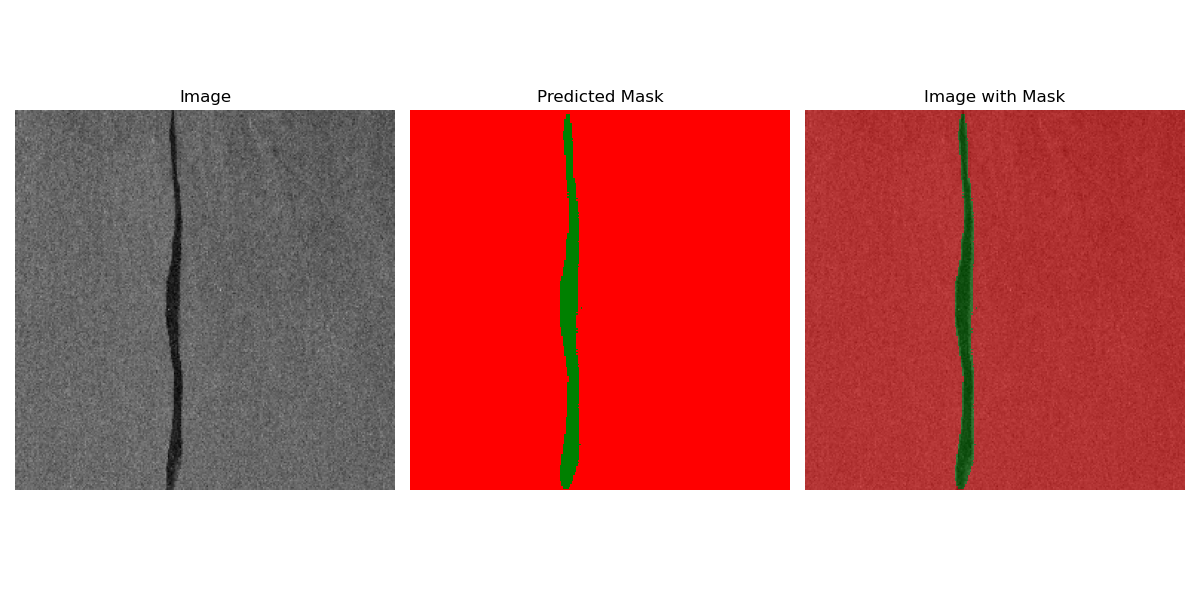

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from IPython.display import Image as IPImage, display

# Define COLOR_MAP and cmap if needed
# For demonstration, let's assume a default colormap
COLOR_MAP = ['red', 'green', 'blue']  # Example color map
cmap = plt.cm.colors.ListedColormap(COLOR_MAP)

# Load your pre-trained model
# unet_model = tf.keras.models.load_model('path_to_your_model')

def predict_mask(image):
    """
    Function to predict the mask of an input image using the unet_model.
    """
    # Ensure image has the correct shape (256, 256, 3) or modify as necessary
    image = tf.image.resize(image, [256, 256])
    image = np.array(image) / 255.0  # Normalize image if required

    # Predict the mask
    prediction_unet = unet_model.predict(np.expand_dims(image, axis=0))
    predicted_mask_unet = np.argmax(prediction_unet, axis=3)[0, :, :]

    # Plotting images using matplotlib
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    # Display original image
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    # Display predicted mask
    axes[1].imshow(predicted_mask_unet, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')

    # Overlay mask on image
    axes[2].imshow(image)
    axes[2].imshow(predicted_mask_unet, cmap=cmap, alpha=0.5, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    axes[2].set_title("Image with Mask")
    axes[2].axis('off')

    plt.tight_layout()

    # Save plot to a temporary file and return the filepath
    plot_file_path = "/kaggle/working/predicted_output.png"
    plt.savefig(plot_file_path)
    plt.close(fig)

    return plot_file_path

# Upload and process the image
uploaded_image_path = "/kaggle/input/oil-spill/oil-spill/test/images/img_0025.jpg"  # Replace with the path to your uploaded image

# Open and process the uploaded image
input_image = Image.open(uploaded_image_path)
input_image = np.array(input_image)

# Predict mask and save the output
output_path = predict_mask(input_image)

# Display the result
display(IPImage(output_path))
